In [1]:
!git clone https://github.com/ShowStopperTheSecond/tmp /tmp/r2d2 

Cloning into '/tmp/r2d2'...
remote: Enumerating objects: 317, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 317 (delta 110), reused 124 (delta 54), pack-reused 136
Receiving objects: 100% (317/317), 154.74 MiB | 28.83 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [2]:
!unlink /tmp/r2d2/data
!mkdir -p /tmp/r2d2/data/sar/
!ln -s /kaggle/input/sar-patches/sentinel_1/Training /tmp/r2d2/data/sar/optical_flow 

!ln -s /kaggle/input/naturalimages/aachen /tmp/r2d2/data/aachen 
# !ln -s /kaggle/input/naturalimages/revisitop1m /tmp/r2d2/data/revisitop1m 

In [3]:
!unlink /kaggle/input/naturalimages/revisitop1m

unlink: cannot unlink '/kaggle/input/naturalimages/revisitop1m': Read-only file system


In [4]:
ls /tmp/r2d2/data

aachen@  sar/


In [5]:
# !pip uninstall -y pytorch_metric_learning

In [6]:
# import sys
# desired_path = "/tmp/r2d2"
# if desired_path not in sys.path:
#     sys.path.append(desired_path)
    

In [7]:
cd /tmp/r2d2

/tmp/r2d2


In [8]:
!git pull

Already up to date.


In [9]:
ls

LICENSE*    download_training_data.sh*  mask.npy*  train_custom.py*
NOTICE*     extract.py*                 nets/      transformation.npy*
README.md*  extract_kapture.py*         pc_data@   viz_heatmaps.py*
aflow.npy*  img1.npy*                   results/
data/       img2.npy*                   tools/
datasets/   imgs/                       train.py*


In [10]:
import os, pdb
import torch
import torch.optim as optim

from tools import common, trainer
from tools.dataloader import *
from nets.patchnet import *
from nets.losses import *
import torchvision.transforms.functional as transform
from PIL import Image, ImageOps
from tqdm.notebook import tqdm
import warnings
from  datasets import *
import matplotlib.pyplot as plt
import cv2

warnings.filterwarnings("ignore")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Caching:   0%|          | 0/208 [00:00<?, ?it/s]


aachen_db_images: successful 
aachen_style_transfer_pairs: successful 
aachen_flow_pairs : successful 


Dataset SAR_db_images not available, reason: Empty SAR dataset


sar_db_flow: successful 


In [11]:
default_net = "Quad_L2Net_ConfCFS()"
# default_net = "Custom_Quad_L2Net_ConfCFS()"

toy_db_debug = """SyntheticPairDataset(
    ImgFolder('imgs'), 
            'RandomScale(256,1024,can_upscale=True)', 
            'RandomTilting(0.5), PixelNoise(.5)')"""

db_web_images = """SyntheticPairDataset(
    web_images, 
        'RandomScale(256,1024,can_upscale=True)',
        'RandomTilting(0.5), PixelNoise(.5)')"""

db_aachen_images = """SyntheticPairDataset(
    aachen_db_images, 
        'RandomScale(256,1024,can_upscale=True)', 
        'RandomTilting(0.5), PixelNoise(.5)')"""

db_aachen_style_transfer = """TransformedPairs(
    aachen_style_transfer_pairs,
            'RandomScale(256,1024,can_upscale=True), RandomTilting(0.5), PixelNoise(.5)')"""

db_aachen_flow = "aachen_flow_pairs"


db_sar_images = """SyntheticPairDataset(
    sar_db_images, 
        'RandomScale(256,256,can_upscale=False)', 
        'RandomTilting(0.5), PixelSpeckleNoise(.5)')"""

db_sar_flow = " sar_db_flow"



default_dataloader = """PairLoader(CatPairDataset(`data`),
    scale   = 'RandomScale(256,1024,can_upscale=True)',
    crop    = 'RandomCrop(192)')"""

default_sampler = """NghSampler2(ngh=7, subq=-8, subd=1, pos_d=3, neg_d=5, border=16,
                            subd_neg=-8,maxpool_pos=False)"""





data_sources = dict(
    D = toy_db_debug,
    W = db_web_images,
    A = db_aachen_images,
    F = db_aachen_flow,
    S = db_aachen_style_transfer,
    X = db_sar_images,
    Z = db_sar_flow
    )

In [12]:
def fix_img(img):
    c = (img - img.min()) / (img.max() - img.min()) * 255
    return c



class MyTrainer(trainer.Trainer):
    """ This class implements the network training.
        Below is the function I need to overload to explain how to do the backprop.
    """
    def forward_backward(self, inputs):
#         img1 =  np.array(inputs['img1'][0])
#         img2 =  np.array(inputs['img2'][0])
#         mask = np.array(inputs['mask'][0])
#         aflow = np.array(inputs['aflow'][0])
#         np.save('img1', img1)
#         np.save('img2', img2)
#         np.save('mask', mask )
#         np.save('aflow', aflow)
        # np.save('transformation', final_tr_mat)
        images = [inputs.pop('img1'),inputs.pop('img2')]
        output = self.net(imgs=images)
        allvars = dict(inputs, **output)
        loss, details = self.loss_func(**allvars)
        if torch.is_grad_enabled(): loss.backward()
        return loss, details


def load_network(model_fn):
    checkpoint = torch.load(model_fn, map_location=torch.device('cpu'))
    print("\n>> Creating net = " + checkpoint['net'])
    net = eval(checkpoint['net'])
    nb_of_weights = common.model_size(net)
    print(f" ( Model size: {nb_of_weights/1000:.0f}K parameters )")

    # initialization
    weights = checkpoint['state_dict']
    net.load_state_dict({k.replace('module.',''):v for k,v in weights.items()})
    return net.eval()


def load_network_custom(model_fn):
    checkpoint = torch.load(model_fn)
    print("\n>> Creating net = " + str(checkpoint['net']))
    net = checkpoint['net']
    nb_of_weights = common.model_size(net)
    print(f" ( Model size: {nb_of_weights/1000:.0f}K parameters )")
    # initialization
    weights = checkpoint['state_dict']
    net.load_state_dict({k.replace('module.',''):v for k,v in weights.items()})
    return net.eval()


# For evaluating
class NonMaxSuppression(torch.nn.Module):
    def __init__(self, rel_thr=0.7, rep_thr=0.7):
        nn.Module.__init__(self)
        self.max_filter = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.rel_thr = rel_thr
        self.rep_thr = rep_thr

    def forward(self, reliability, repeatability, **kw):
        assert len(reliability) == len(repeatability) == 1
        reliability, repeatability = reliability[0], repeatability[0]

        # local maxima
        maxima = (repeatability == self.max_filter(repeatability))

        # remove low peaks
        maxima *= (repeatability >= self.rep_thr)
        maxima *= (reliability >= self.rel_thr)

        return maxima.nonzero().t()[2:4]


def extract_multiscale(net, img, detector, scale_f=2 ** 0.25,
                       min_scale=0.0, max_scale=1,
                       min_size=256, max_size=1024,
                       verbose=False):
    old_bm = torch.backends.cudnn.benchmark
    torch.backends.cudnn.benchmark = False  # speedup

    # extract keypoints at multiple scales
    B, three, H, W = img.shape
    assert B == 1 and three == 3, "should be a batch with a single RGB image"

    assert max_scale <= 1
    s = 1.0  # current scale factor

    catched = False
    X, Y, S, C, Q, D = [], [], [], [], [], []
    while s + 0.001 >= max(min_scale, min_size / max(H, W)):
        if s - 0.001 <= min(max_scale, max_size / max(H, W)):
            nh, nw = img.shape[2:]
            if verbose: print(f"extracting at scale x{s:.02f} = {nw:4d}x{nh:3d}")
            # extract descriptors
            with torch.no_grad():
                res = net(imgs=[img])

            # get output and reliability map
            descriptors = res['descriptors'][0]
            reliability = res['reliability'][0]
            repeatability = res['repeatability'][0]
            if not catched:
                ret_reliability = reliability.cpu().detach().numpy().squeeze()
                ret_repeatability = repeatability.cpu().detach().numpy().squeeze()
                catched = True

            # normalize the reliability for nms
            # extract maxima and descs
            y, x = detector(**res)  # nms
            c = reliability[0, 0, y, x]
            q = repeatability[0, 0, y, x]
            d = descriptors[0, :, y, x].t()
            n = d.shape[0]

            # accumulate multiple scales
            X.append(x.float() * W / nw)
            Y.append(y.float() * H / nh)
            S.append((32 / s) * torch.ones(n, dtype=torch.float32, device=d.device))
            C.append(c)
            Q.append(q)
            D.append(d)
        s /= scale_f

        # down-scale the image for next iteration
        nh, nw = round(H * s), round(W * s)
        img = torch.nn.functional.interpolate(img, (nh, nw), mode='bilinear', align_corners=False)

    # restore value
    torch.backends.cudnn.benchmark = old_bm

    Y = torch.cat(Y)
    X = torch.cat(X)
    S = torch.cat(S)  # scale
    scores = torch.cat(C) * torch.cat(Q)  # scores = reliability * repeatability
    XYS = torch.stack([X, Y, S], dim=-1)
    D = torch.cat(D)
    return XYS, D, scores, ret_reliability, ret_repeatability

def to_opencv_keypoints(keypoints,size_scale=20):
    converterd_keypoints=[]
    for x, y, scale in keypoints:
        k=cv2.KeyPoint(x=x, y=y, size=scale, angle=0, octave=int(scale))
        converterd_keypoints.append(k)
    return converterd_keypoints
def translatePoint(p, d):
    x, y = p
    dx, dy = d
    return [x + dx, y + dy]

def homographyTransform(h,p):
    res=h@p
    res=res/res[-1]
    return res[:2].astype('int')



def drawMatches(pt1, img1, pt2, img2, mask, h_mat):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img = np.zeros(shape=(max(h1, h2), w1 + w2), dtype='uint8')
    img[:h1, :w1] = img1
    img[:h2, w1:] = img2
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    x = []
    x.append([0, 0, 1])
    x.append([w1, 0, 1])
    x.append([w1, h1, 1])
    x.append([0, h1, 1])

    tx = [translatePoint(homographyTransform(h_mat, np.array(p)), (w1, 0)) for p in x]
    tx = np.array([tx])
    for i, m in enumerate(mask):
        if m == 1:
            dst = (int(w1 + pt2[i][0]), int(pt2[i][1]))
            src = (int(pt1[i][0]), int(pt1[i][1]))
            #             color=tuple(np.random.randint(0,255,3,dtype='int'))
            color = np.random.randint(0, 255, size=(3), dtype=np.uint8)
            color = (int(color[0]), int(color[1]), int(color[2]))
            cv2.line(img, src, dst, color, thickness=1)
    cv2.polylines(img, tx, isClosed=True, color=color, thickness=2)
    plt.figure(figsize=(20, 18))
    plt.imshow(img)
    plt.show()
    return img
def homographyAddTranslation(h, translation):
    h_t = np.eye(3)
    h_t[0, 2] = translation[1]
    h_t[1, 2] = translation[0]
    return h_t @ h

def crop_image(img,percentile=.6):
    height,width=img.shape[:2]
    h=int(percentile*height/2)
    w=int(percentile*width/2)
    return img[h:-h,w:-w]

def grid_img(img,grid_size=60):
    data=img.copy()
    h,w=img.shape[:2]
    n_h=h//grid_size
    n_w=w//grid_size
    skip=-1
    for m in range(n_h-1):
        for n in range(n_w-1):
            skip*=-1
            if skip==1:
                data[m*grid_size:(m+1)*grid_size,n*grid_size:(n+1)*grid_size]=0
    return data
def stichImages(img1, img2, h):
    dst_h, dst_w = img2.shape[:2]
    dst_shape = (dst_w * 3, dst_h * 3)
    h = homographyAddTranslation(h, (dst_h, dst_w))
    img = cv2.warpPerspective(img1, h, dst_shape)
#     fig, ax = plt.subplots(1, 2, figsize=(20, 18))
    padded_img = np.pad(img2, [[dst_h, dst_h], [dst_w, dst_w]])
#     ax[0].imshow(img)
#     ax[1].imshow(padded_img)
#     plt.show()
    img_registeded = padded_img.copy()
    img=grid_img(img)
    img_registeded[img != 0] = img[img != 0]
    img_registeded=crop_image(img_registeded)
    plt.figure(figsize=(14, 10))
    plt.imshow(img_registeded)
    plt.show()
    return


def test_network(img1_rgb, img2_rgb, net, detector):
    img1 = norm_RGB(img1_rgb)[None].cuda()
    xys_img1, desc_img1, scores_img1, reliability_img1, repeatability_img1 = extract_multiscale(net, img1, detector,
                                                                                                min_size=64,
                                                                                                verbose=False)
    img2 = norm_RGB(img2_rgb)[None].cuda()
    xys_img2, desc_img2, scores_img2, reliability_img2, repeatability_img2 = extract_multiscale(net, img2, detector,
                                                                                                min_size=64,
                                                                                                verbose=False)

    fig, ax = plt.subplots(2, 3, figsize=(20, 8))
    ax[0, 0].imshow(img1_rgb)
    pos = ax[0, 1].imshow(reliability_img1)
    plt.colorbar(pos, ax=ax[0, 1])
    pos = ax[0, 2].imshow(repeatability_img1)
    plt.colorbar(pos, ax=ax[0, 2])
    ax[1, 0].imshow(img2_rgb)
    pos = ax[1, 1].imshow(reliability_img2)
    plt.colorbar(pos, ax=ax[1, 1])
    pos = ax[1, 2].imshow(repeatability_img2)
    plt.colorbar(pos, ax=ax[1, 2])
    plt.show()

    kps1 = xys_img1.cpu().detach().numpy()
    scores1 = scores_img1.cpu().detach().numpy()
    descs1 = desc_img1.cpu().detach().numpy()
    kp1 = np.array([kp for kp, score, desc in zip(kps1, scores1, descs1) if score > reliability_thr])
    desc1 = np.array([desc for kp, score, desc in zip(kps1, scores1, descs1) if score > reliability_thr])

    kps2 = xys_img2.cpu().detach().numpy()
    scores2 = scores_img2.cpu().detach().numpy()
    descs2 = desc_img2.cpu().detach().numpy()
    kp2 = np.array([kp for kp, score, desc in zip(kps2, scores2, descs2) if score > reliability_thr])
    desc2 = np.array([desc for kp, score, desc in zip(kps2, scores2, descs2) if score > reliability_thr])
    fig, ax = plt.subplots(1 ,2, figsize=(20, 10))
    if len(kp1) <2 or len(kp2)< 2: return
    ax[0].imshow(img2_rgb)
    ax[0].scatter(x=kp2[:, 0], y=kp2[:, 1], marker='x', linewidths=1, c='r', s=150)
    ax[1].imshow(img1_rgb)
    ax[1].scatter(x=kp1[:, 0], y=kp1[:, 1], marker='x', linewidths=1, c='r', s=150)
    plt.show()
    keys1 = to_opencv_keypoints(kp1)
    keys2 = to_opencv_keypoints(kp2)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.95 * n.distance:
            good_matches.append([m])

    # cv2.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1_rgb, keys1, img2_rgb, keys2, good_matches, outImg=None, flags=2)
    plt.figure(figsize=(20, 18))
    plt.imshow(img3)
    pt1 = [kp1[m[0].queryIdx][:2] for m in good_matches]
    pt2 = [kp2[m[0].trainIdx][:2] for m in good_matches]
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    plt.show()
    h, mask = cv2.findHomography(srcPoints=pt1, dstPoints=pt2, method=cv2.FM_RANSAC, ransacReprojThreshold=5)
    imgg = drawMatches(pt1, img1_rgb[...,0], pt2, img2_rgb[..., 0], mask, h)
    plt.show()
    img = cv2.warpPerspective(img1_rgb[...,0], h, img2_rgb[...,0].shape[::-1])
    img_registeded = stichImages(img1_rgb[...,0], img2_rgb[...,0], h)
    plt.show()

In [13]:
reliability_thr = 0.7
repeatability_thr = .7

In [14]:
# Training loop #
# img1 = cv2.imread("/kaggle/input/some-registered-images/box.png")
# img2 = cv2.imread("/kaggle/input/some-registered-images/box_in_scene.png")
img1 = cv2.imread("/kaggle/input/some-registered-images/c1.jpg")
img2 = cv2.imread("/kaggle/input/some-registered-images/c2.jpg")


detector = NonMaxSuppression(rel_thr = reliability_thr, rep_thr = repeatability_thr)

save_path = "/kaggle/working//saved_model.pt"
gpu = 0
# train_data = "ASF"
# train_data = "F"
train_data = "Z"



data_loader = default_dataloader
threads = 8
batch_size = 4
net = default_net
N = patch_size = 16
learning_rate = 5e-3
weight_decay = 1e-3
epochs = 100
# network_path = "./models/faster2d2_WASF_N16.pt"


iscuda = common.torch_set_gpu(gpu)
# iscuda = False
common.mkdir_for(save_path)


# Create data loader
db = [data_sources[key] for key in train_data]
x = data_loader.replace('`data`',','.join(db)).replace('\n','')
print(x)
db = eval(data_loader.replace('`data`',','.join(db)).replace('\n',''))
print("Training image database =", db)
loader = threaded_loader(db, False, threads, batch_size, shuffle=True)
for a in loader:
    b = a
    break

Launching on GPUs 0
PairLoader(CatPairDataset( sar_db_flow),    scale   = 'RandomScale(256,1024,can_upscale=True)',    crop    = 'RandomCrop(192)')
Training image database = PairLoader
CatPairDataset(Dataset: SAR_OpticalFlow   567 images, 567 image pairs   root: ... )  npairs: 567
  Distort: 
  Crop: RandomCrop((192, 192)), 
  Norm: ToTensor(),  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 



In [15]:
# net = load_network(network_path)
net = Custom_Quad_L2Net_ConfCFS()
# net = Quad_L2Net_ConfCFS()

In [16]:
net

Custom_Quad_L2Net_ConfCFS(
  (ops): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): GrowingCosineUnit()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): GrowingCosineUnit()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): GrowingCosineUnit()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): GrowingCosineUnit()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False

In [17]:
# default_sampler = """NghSampler2MultiDescriptor(ngh=7, subq=-8, subd=1, pos_d=3, neg_d=5, border=16,
#                             subd_neg=-8,maxpool_pos=True)"""

default_sampler = """NghSampler2(ngh=7, subq=-8, subd=1, pos_d=3, neg_d=5, border=16,
                            subd_neg=-8,maxpool_pos=False)"""





default_loss = """MultiLoss(
        1, ReliabilityLoss(`sampler`, base=0.5, nq=20),
        1, CosimLoss(N=`N`),
        1, PeakyLoss(N=`N`))"""
sampler = default_sampler
loss = default_loss



In [18]:
# create losses
loss = loss.replace('`sampler`',sampler).replace('`N`',str(patch_size))
print("\n>> Creating loss = " + loss)
loss = eval(loss.replace('\n',''))


# create optimizer
optimizer = optim.Adam( [p for p in net.parameters() if p.requires_grad],
                        lr=learning_rate, weight_decay=weight_decay)

train = MyTrainer(net, loader, loss, optimizer)
if iscuda: train = train.cuda()


>> Creating loss = MultiLoss(
        1, ReliabilityLoss(NghSampler2(ngh=7, subq=-8, subd=1, pos_d=3, neg_d=5, border=16,
                            subd_neg=-8,maxpool_pos=False), base=0.5, nq=20),
        1, CosimLoss(N=16),
        1, PeakyLoss(N=16))


In [19]:
#  test_network(img1, img2, net, detector)


>> Starting epoch 0...


100%|██████████| 142/142 [01:34<00:00,  1.51it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.557 --> 0.501 (avg: 0.507)
  - loss_cosim16        : 0.050 --> 0.108 (avg: 0.100)
  - loss_peaky16        : 0.815 --> 0.487 (avg: 0.563)
  - loss                : 1.422 --> 1.096 (avg: 1.169)


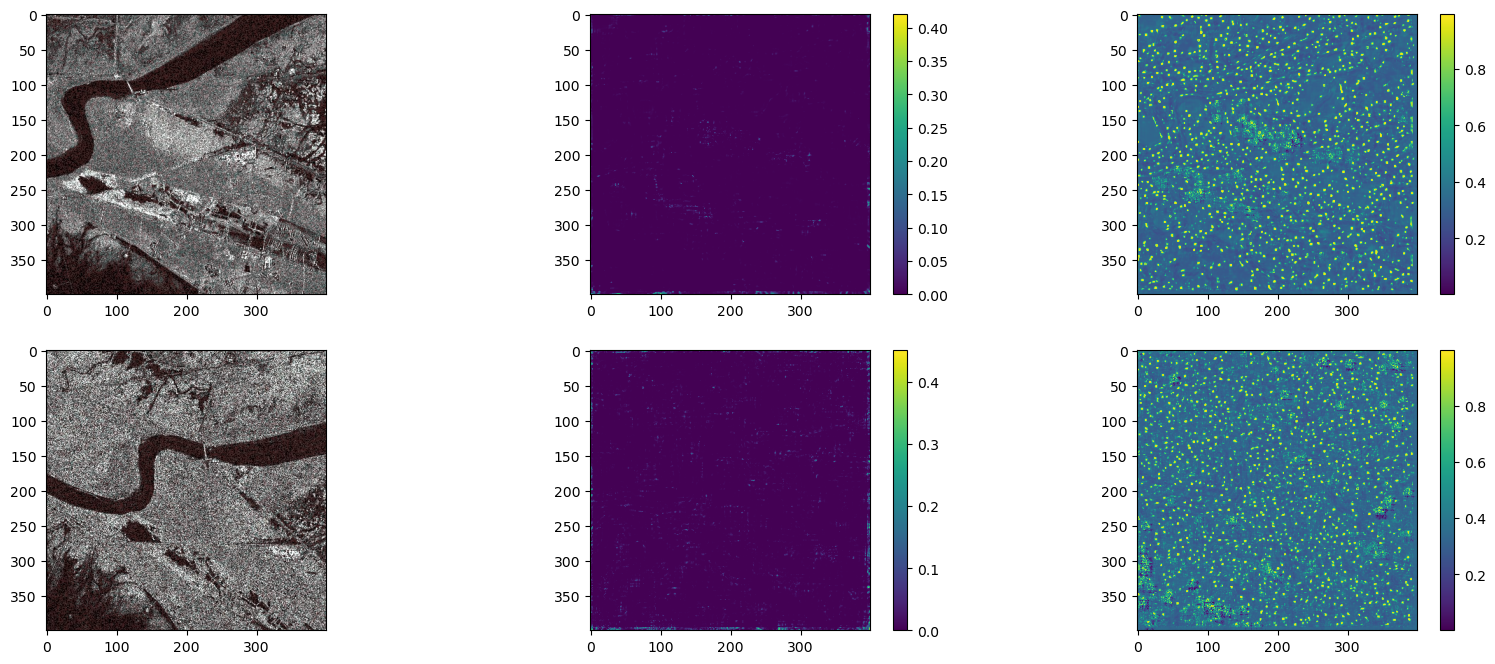


>> Starting epoch 1...


100%|██████████| 142/142 [01:15<00:00,  1.88it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.501)
  - loss_cosim16        : 0.114 --> 0.112 (avg: 0.112)
  - loss_peaky16        : 0.464 --> 0.463 (avg: 0.461)
  - loss                : 1.078 --> 1.075 (avg: 1.074)

>> Starting epoch 2...


100%|██████████| 142/142 [01:14<00:00,  1.90it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.503 (avg: 0.501)
  - loss_cosim16        : 0.111 --> 0.112 (avg: 0.112)
  - loss_peaky16        : 0.450 --> 0.475 (avg: 0.449)
  - loss                : 1.062 --> 1.089 (avg: 1.062)

>> Starting epoch 3...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.112 --> 0.113 (avg: 0.114)
  - loss_peaky16        : 0.461 --> 0.448 (avg: 0.444)
  - loss                : 1.073 --> 1.062 (avg: 1.058)

>> Starting epoch 4...


100%|██████████| 142/142 [01:15<00:00,  1.88it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.117 --> 0.116 (avg: 0.115)
  - loss_peaky16        : 0.432 --> 0.437 (avg: 0.442)
  - loss                : 1.049 --> 1.053 (avg: 1.057)

>> Starting epoch 5...


100%|██████████| 142/142 [01:15<00:00,  1.89it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.115 (avg: 0.116)
  - loss_peaky16        : 0.431 --> 0.415 (avg: 0.430)
  - loss                : 1.047 --> 1.030 (avg: 1.046)

>> Starting epoch 6...


100%|██████████| 142/142 [01:14<00:00,  1.90it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.115 --> 0.124 (avg: 0.116)
  - loss_peaky16        : 0.427 --> 0.411 (avg: 0.433)
  - loss                : 1.042 --> 1.036 (avg: 1.049)

>> Starting epoch 7...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.114 --> 0.112 (avg: 0.116)
  - loss_peaky16        : 0.433 --> 0.446 (avg: 0.427)
  - loss                : 1.047 --> 1.058 (avg: 1.044)

>> Starting epoch 8...


100%|██████████| 142/142 [01:15<00:00,  1.88it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.117 --> 0.112 (avg: 0.116)
  - loss_peaky16        : 0.430 --> 0.450 (avg: 0.430)
  - loss                : 1.048 --> 1.062 (avg: 1.046)

>> Starting epoch 9...


100%|██████████| 142/142 [01:15<00:00,  1.89it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.112 --> 0.119 (avg: 0.116)
  - loss_peaky16        : 0.457 --> 0.418 (avg: 0.436)
  - loss                : 1.069 --> 1.037 (avg: 1.052)

>> Starting epoch 10...


100%|██████████| 142/142 [01:15<00:00,  1.88it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.111 (avg: 0.115)
  - loss_peaky16        : 0.446 --> 0.447 (avg: 0.436)
  - loss                : 1.062 --> 1.059 (avg: 1.051)

>> Starting epoch 11...


100%|██████████| 142/142 [01:15<00:00,  1.88it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.114 (avg: 0.115)
  - loss_peaky16        : 0.448 --> 0.438 (avg: 0.444)
  - loss                : 1.064 --> 1.052 (avg: 1.059)

>> Starting epoch 12...


100%|██████████| 142/142 [01:15<00:00,  1.89it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.114 --> 0.117 (avg: 0.115)
  - loss_peaky16        : 0.426 --> 0.434 (avg: 0.443)
  - loss                : 1.041 --> 1.051 (avg: 1.059)

>> Starting epoch 13...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.111 --> 0.109 (avg: 0.113)
  - loss_peaky16        : 0.464 --> 0.450 (avg: 0.451)
  - loss                : 1.075 --> 1.059 (avg: 1.064)

>> Starting epoch 14...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.118 --> 0.118 (avg: 0.117)
  - loss_peaky16        : 0.436 --> 0.423 (avg: 0.432)
  - loss                : 1.054 --> 1.041 (avg: 1.049)

>> Starting epoch 15...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.103 --> 0.117 (avg: 0.113)
  - loss_peaky16        : 0.505 --> 0.439 (avg: 0.456)
  - loss                : 1.109 --> 1.056 (avg: 1.070)

>> Starting epoch 16...


100%|██████████| 142/142 [01:12<00:00,  1.95it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.115 --> 0.122 (avg: 0.114)
  - loss_peaky16        : 0.443 --> 0.462 (avg: 0.452)
  - loss                : 1.059 --> 1.084 (avg: 1.067)

>> Starting epoch 17...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.101 --> 0.110 (avg: 0.112)
  - loss_peaky16        : 0.484 --> 0.448 (avg: 0.454)
  - loss                : 1.085 --> 1.059 (avg: 1.066)

>> Starting epoch 18...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.111 --> 0.117 (avg: 0.114)
  - loss_peaky16        : 0.475 --> 0.437 (avg: 0.448)
  - loss                : 1.087 --> 1.054 (avg: 1.062)

>> Starting epoch 19...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.116 (avg: 0.115)
  - loss_peaky16        : 0.440 --> 0.447 (avg: 0.447)
  - loss                : 1.056 --> 1.064 (avg: 1.062)

>> Starting epoch 20...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.120 --> 0.109 (avg: 0.114)
  - loss_peaky16        : 0.441 --> 0.462 (avg: 0.451)
  - loss                : 1.062 --> 1.071 (avg: 1.066)

>> Starting epoch 21...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.501)
  - loss_cosim16        : 0.113 --> 0.121 (avg: 0.116)
  - loss_peaky16        : 0.447 --> 0.433 (avg: 0.446)
  - loss                : 1.060 --> 1.054 (avg: 1.063)

>> Starting epoch 22...


100%|██████████| 142/142 [01:14<00:00,  1.90it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.111 --> 0.109 (avg: 0.112)
  - loss_peaky16        : 0.444 --> 0.462 (avg: 0.453)
  - loss                : 1.056 --> 1.071 (avg: 1.066)

>> Starting epoch 23...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.113 (avg: 0.116)
  - loss_peaky16        : 0.464 --> 0.449 (avg: 0.445)
  - loss                : 1.081 --> 1.062 (avg: 1.061)

>> Starting epoch 24...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.118 --> 0.114 (avg: 0.114)
  - loss_peaky16        : 0.442 --> 0.448 (avg: 0.446)
  - loss                : 1.060 --> 1.062 (avg: 1.060)

>> Starting epoch 25...


100%|██████████| 142/142 [01:16<00:00,  1.87it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.113 --> 0.112 (avg: 0.114)
  - loss_peaky16        : 0.441 --> 0.459 (avg: 0.448)
  - loss                : 1.055 --> 1.072 (avg: 1.062)

>> Starting epoch 26...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.115 (avg: 0.114)
  - loss_peaky16        : 0.456 --> 0.442 (avg: 0.456)
  - loss                : 1.072 --> 1.057 (avg: 1.070)

>> Starting epoch 27...


100%|██████████| 142/142 [01:12<00:00,  1.95it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.112 --> 0.107 (avg: 0.115)
  - loss_peaky16        : 0.448 --> 0.446 (avg: 0.445)
  - loss                : 1.060 --> 1.054 (avg: 1.060)

>> Starting epoch 28...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.123 --> 0.112 (avg: 0.115)
  - loss_peaky16        : 0.445 --> 0.453 (avg: 0.448)
  - loss                : 1.069 --> 1.066 (avg: 1.063)

>> Starting epoch 29...


100%|██████████| 142/142 [01:12<00:00,  1.95it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.114 --> 0.118 (avg: 0.114)
  - loss_peaky16        : 0.460 --> 0.440 (avg: 0.452)
  - loss                : 1.075 --> 1.058 (avg: 1.066)

>> Starting epoch 30...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.105 --> 0.112 (avg: 0.113)
  - loss_peaky16        : 0.466 --> 0.472 (avg: 0.455)
  - loss                : 1.072 --> 1.084 (avg: 1.069)

>> Starting epoch 31...


100%|██████████| 142/142 [01:13<00:00,  1.92it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.114 --> 0.109 (avg: 0.114)
  - loss_peaky16        : 0.445 --> 0.468 (avg: 0.442)
  - loss                : 1.059 --> 1.078 (avg: 1.057)

>> Starting epoch 32...


100%|██████████| 142/142 [01:14<00:00,  1.90it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.113 --> 0.107 (avg: 0.114)
  - loss_peaky16        : 0.461 --> 0.451 (avg: 0.451)
  - loss                : 1.075 --> 1.058 (avg: 1.065)

>> Starting epoch 33...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.124 --> 0.119 (avg: 0.115)
  - loss_peaky16        : 0.429 --> 0.446 (avg: 0.454)
  - loss                : 1.053 --> 1.066 (avg: 1.070)

>> Starting epoch 34...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.105 --> 0.118 (avg: 0.112)
  - loss_peaky16        : 0.467 --> 0.443 (avg: 0.456)
  - loss                : 1.072 --> 1.062 (avg: 1.069)

>> Starting epoch 35...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.117 --> 0.114 (avg: 0.115)
  - loss_peaky16        : 0.438 --> 0.432 (avg: 0.443)
  - loss                : 1.055 --> 1.046 (avg: 1.059)

>> Starting epoch 36...


100%|██████████| 142/142 [01:14<00:00,  1.92it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.117 --> 0.117 (avg: 0.115)
  - loss_peaky16        : 0.451 --> 0.440 (avg: 0.450)
  - loss                : 1.068 --> 1.057 (avg: 1.065)

>> Starting epoch 37...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.111 --> 0.111 (avg: 0.114)
  - loss_peaky16        : 0.447 --> 0.466 (avg: 0.452)
  - loss                : 1.059 --> 1.078 (avg: 1.066)

>> Starting epoch 38...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.501)
  - loss_cosim16        : 0.110 --> 0.106 (avg: 0.110)
  - loss_peaky16        : 0.457 --> 0.499 (avg: 0.466)
  - loss                : 1.067 --> 1.105 (avg: 1.077)

>> Starting epoch 39...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.115 (avg: 0.115)
  - loss_peaky16        : 0.466 --> 0.438 (avg: 0.455)
  - loss                : 1.082 --> 1.054 (avg: 1.070)

>> Starting epoch 40...


100%|██████████| 142/142 [01:13<00:00,  1.92it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.115 (avg: 0.113)
  - loss_peaky16        : 0.440 --> 0.470 (avg: 0.457)
  - loss                : 1.056 --> 1.085 (avg: 1.071)

>> Starting epoch 41...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.113 --> 0.120 (avg: 0.115)
  - loss_peaky16        : 0.478 --> 0.449 (avg: 0.450)
  - loss                : 1.092 --> 1.069 (avg: 1.066)

>> Starting epoch 42...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.117 --> 0.113 (avg: 0.115)
  - loss_peaky16        : 0.460 --> 0.439 (avg: 0.443)
  - loss                : 1.077 --> 1.052 (avg: 1.058)

>> Starting epoch 43...


100%|██████████| 142/142 [01:12<00:00,  1.95it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.118 --> 0.114 (avg: 0.113)
  - loss_peaky16        : 0.428 --> 0.451 (avg: 0.457)
  - loss                : 1.047 --> 1.065 (avg: 1.071)

>> Starting epoch 44...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.112 --> 0.111 (avg: 0.114)
  - loss_peaky16        : 0.473 --> 0.447 (avg: 0.456)
  - loss                : 1.084 --> 1.059 (avg: 1.070)

>> Starting epoch 45...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.119 --> 0.115 (avg: 0.113)
  - loss_peaky16        : 0.427 --> 0.434 (avg: 0.452)
  - loss                : 1.046 --> 1.049 (avg: 1.065)

>> Starting epoch 46...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.120 --> 0.110 (avg: 0.114)
  - loss_peaky16        : 0.431 --> 0.463 (avg: 0.453)
  - loss                : 1.052 --> 1.073 (avg: 1.067)

>> Starting epoch 47...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.114 --> 0.119 (avg: 0.116)
  - loss_peaky16        : 0.455 --> 0.438 (avg: 0.443)
  - loss                : 1.070 --> 1.057 (avg: 1.060)

>> Starting epoch 48...


100%|██████████| 142/142 [01:13<00:00,  1.92it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.117 --> 0.114 (avg: 0.114)
  - loss_peaky16        : 0.424 --> 0.470 (avg: 0.448)
  - loss                : 1.041 --> 1.085 (avg: 1.062)

>> Starting epoch 49...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.115 --> 0.107 (avg: 0.114)
  - loss_peaky16        : 0.451 --> 0.485 (avg: 0.454)
  - loss                : 1.066 --> 1.092 (avg: 1.068)

>> Starting epoch 50...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.119 --> 0.108 (avg: 0.113)
  - loss_peaky16        : 0.442 --> 0.460 (avg: 0.455)
  - loss                : 1.062 --> 1.068 (avg: 1.068)


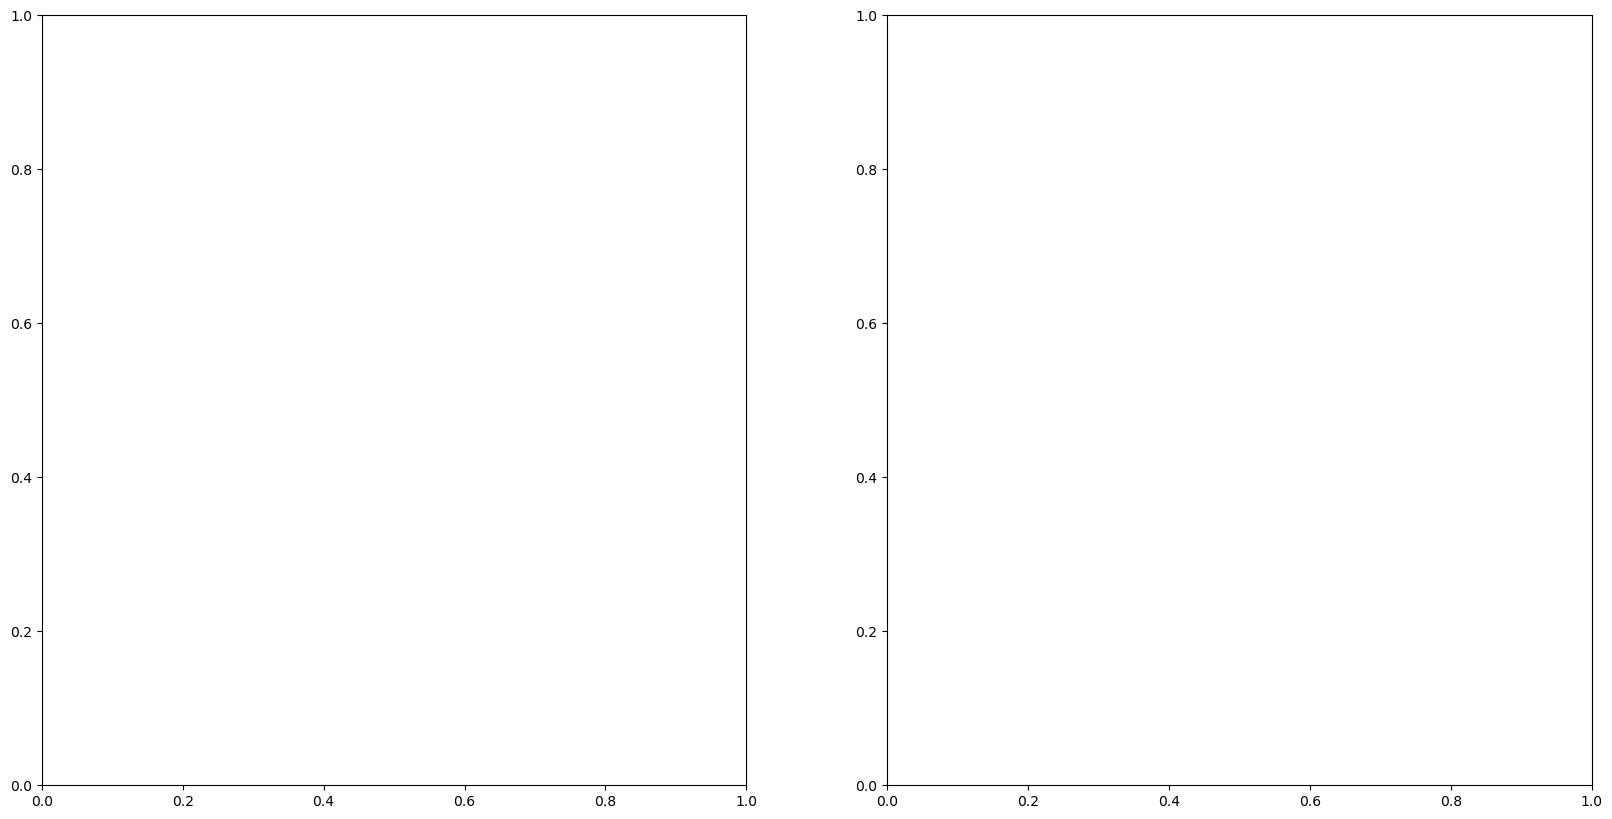

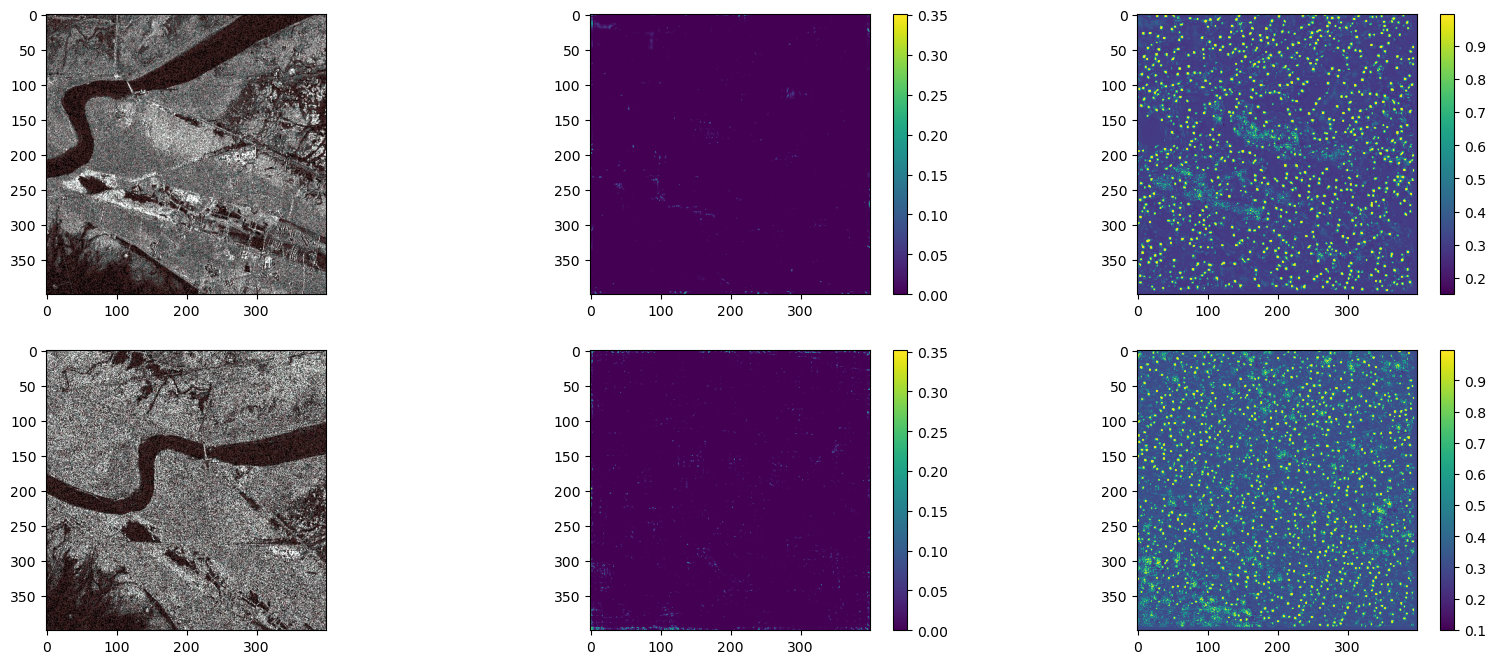


>> Starting epoch 51...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.121 --> 0.123 (avg: 0.114)
  - loss_peaky16        : 0.441 --> 0.429 (avg: 0.453)
  - loss                : 1.063 --> 1.053 (avg: 1.068)

>> Starting epoch 52...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.501)
  - loss_cosim16        : 0.114 --> 0.119 (avg: 0.116)
  - loss_peaky16        : 0.439 --> 0.439 (avg: 0.456)
  - loss                : 1.054 --> 1.059 (avg: 1.073)

>> Starting epoch 53...


100%|██████████| 142/142 [01:13<00:00,  1.92it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.119 --> 0.113 (avg: 0.116)
  - loss_peaky16        : 0.443 --> 0.457 (avg: 0.442)
  - loss                : 1.063 --> 1.070 (avg: 1.059)

>> Starting epoch 54...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.112 --> 0.114 (avg: 0.114)
  - loss_peaky16        : 0.475 --> 0.450 (avg: 0.448)
  - loss                : 1.087 --> 1.064 (avg: 1.062)

>> Starting epoch 55...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.112 --> 0.120 (avg: 0.115)
  - loss_peaky16        : 0.443 --> 0.430 (avg: 0.448)
  - loss                : 1.055 --> 1.051 (avg: 1.064)

>> Starting epoch 56...


100%|██████████| 142/142 [01:12<00:00,  1.95it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.114 --> 0.120 (avg: 0.115)
  - loss_peaky16        : 0.458 --> 0.433 (avg: 0.442)
  - loss                : 1.072 --> 1.053 (avg: 1.057)

>> Starting epoch 57...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.117 --> 0.112 (avg: 0.114)
  - loss_peaky16        : 0.429 --> 0.481 (avg: 0.449)
  - loss                : 1.046 --> 1.093 (avg: 1.064)

>> Starting epoch 58...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.110 --> 0.112 (avg: 0.113)
  - loss_peaky16        : 0.462 --> 0.459 (avg: 0.462)
  - loss                : 1.072 --> 1.071 (avg: 1.075)

>> Starting epoch 59...


100%|██████████| 142/142 [01:12<00:00,  1.95it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.120 --> 0.116 (avg: 0.116)
  - loss_peaky16        : 0.430 --> 0.427 (avg: 0.439)
  - loss                : 1.050 --> 1.043 (avg: 1.056)

>> Starting epoch 60...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.501)
  - loss_cosim16        : 0.119 --> 0.124 (avg: 0.114)
  - loss_peaky16        : 0.421 --> 0.418 (avg: 0.452)
  - loss                : 1.040 --> 1.042 (avg: 1.067)

>> Starting epoch 61...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.113 --> 0.109 (avg: 0.116)
  - loss_peaky16        : 0.440 --> 0.473 (avg: 0.445)
  - loss                : 1.054 --> 1.083 (avg: 1.061)

>> Starting epoch 62...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.113 --> 0.111 (avg: 0.116)
  - loss_peaky16        : 0.452 --> 0.441 (avg: 0.442)
  - loss                : 1.066 --> 1.052 (avg: 1.058)

>> Starting epoch 63...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.117 --> 0.116 (avg: 0.115)
  - loss_peaky16        : 0.448 --> 0.438 (avg: 0.442)
  - loss                : 1.066 --> 1.054 (avg: 1.057)

>> Starting epoch 64...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.106 --> 0.117 (avg: 0.115)
  - loss_peaky16        : 0.479 --> 0.443 (avg: 0.443)
  - loss                : 1.086 --> 1.060 (avg: 1.059)

>> Starting epoch 65...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.115 --> 0.114 (avg: 0.113)
  - loss_peaky16        : 0.437 --> 0.452 (avg: 0.456)
  - loss                : 1.053 --> 1.066 (avg: 1.069)

>> Starting epoch 66...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.123 --> 0.114 (avg: 0.114)
  - loss_peaky16        : 0.433 --> 0.444 (avg: 0.449)
  - loss                : 1.056 --> 1.058 (avg: 1.064)

>> Starting epoch 67...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.122 --> 0.117 (avg: 0.116)
  - loss_peaky16        : 0.428 --> 0.438 (avg: 0.444)
  - loss                : 1.050 --> 1.055 (avg: 1.061)

>> Starting epoch 68...


100%|██████████| 142/142 [01:12<00:00,  1.96it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.114 (avg: 0.115)
  - loss_peaky16        : 0.451 --> 0.446 (avg: 0.447)
  - loss                : 1.067 --> 1.061 (avg: 1.062)

>> Starting epoch 69...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.119 --> 0.118 (avg: 0.115)
  - loss_peaky16        : 0.436 --> 0.443 (avg: 0.450)
  - loss                : 1.054 --> 1.061 (avg: 1.065)

>> Starting epoch 70...


100%|██████████| 142/142 [01:13<00:00,  1.92it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.119 --> 0.122 (avg: 0.112)
  - loss_peaky16        : 0.433 --> 0.430 (avg: 0.471)
  - loss                : 1.053 --> 1.053 (avg: 1.083)

>> Starting epoch 71...


100%|██████████| 142/142 [01:12<00:00,  1.96it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.109 --> 0.118 (avg: 0.114)
  - loss_peaky16        : 0.458 --> 0.433 (avg: 0.449)
  - loss                : 1.067 --> 1.051 (avg: 1.064)

>> Starting epoch 72...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.106 --> 0.113 (avg: 0.115)
  - loss_peaky16        : 0.442 --> 0.436 (avg: 0.438)
  - loss                : 1.049 --> 1.049 (avg: 1.054)

>> Starting epoch 73...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.118 --> 0.113 (avg: 0.116)
  - loss_peaky16        : 0.433 --> 0.442 (avg: 0.451)
  - loss                : 1.051 --> 1.056 (avg: 1.067)

>> Starting epoch 74...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.119 --> 0.111 (avg: 0.114)
  - loss_peaky16        : 0.426 --> 0.464 (avg: 0.451)
  - loss                : 1.045 --> 1.075 (avg: 1.065)

>> Starting epoch 75...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.105 --> 0.114 (avg: 0.115)
  - loss_peaky16        : 0.493 --> 0.441 (avg: 0.448)
  - loss                : 1.098 --> 1.056 (avg: 1.063)

>> Starting epoch 76...


100%|██████████| 142/142 [01:12<00:00,  1.95it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.113 (avg: 0.116)
  - loss_peaky16        : 0.434 --> 0.433 (avg: 0.455)
  - loss                : 1.050 --> 1.047 (avg: 1.071)

>> Starting epoch 77...


100%|██████████| 142/142 [01:13<00:00,  1.92it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.123 --> 0.115 (avg: 0.115)
  - loss_peaky16        : 0.434 --> 0.454 (avg: 0.450)
  - loss                : 1.058 --> 1.069 (avg: 1.066)

>> Starting epoch 78...


100%|██████████| 142/142 [01:12<00:00,  1.95it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.109 --> 0.120 (avg: 0.116)
  - loss_peaky16        : 0.465 --> 0.448 (avg: 0.444)
  - loss                : 1.074 --> 1.069 (avg: 1.060)

>> Starting epoch 79...


100%|██████████| 142/142 [01:12<00:00,  1.95it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.126 (avg: 0.117)
  - loss_peaky16        : 0.442 --> 0.426 (avg: 0.446)
  - loss                : 1.059 --> 1.053 (avg: 1.064)

>> Starting epoch 80...


100%|██████████| 142/142 [01:13<00:00,  1.92it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.110 --> 0.112 (avg: 0.113)
  - loss_peaky16        : 0.438 --> 0.471 (avg: 0.449)
  - loss                : 1.048 --> 1.084 (avg: 1.063)

>> Starting epoch 81...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.112 --> 0.112 (avg: 0.112)
  - loss_peaky16        : 0.459 --> 0.461 (avg: 0.459)
  - loss                : 1.072 --> 1.073 (avg: 1.072)

>> Starting epoch 82...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.501)
  - loss_cosim16        : 0.118 --> 0.120 (avg: 0.115)
  - loss_peaky16        : 0.443 --> 0.436 (avg: 0.457)
  - loss                : 1.061 --> 1.057 (avg: 1.072)

>> Starting epoch 83...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.108 --> 0.109 (avg: 0.115)
  - loss_peaky16        : 0.461 --> 0.464 (avg: 0.454)
  - loss                : 1.070 --> 1.073 (avg: 1.069)

>> Starting epoch 84...


100%|██████████| 142/142 [01:12<00:00,  1.95it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.112 --> 0.137 (avg: 0.116)
  - loss_peaky16        : 0.456 --> 0.495 (avg: 0.461)
  - loss                : 1.069 --> 1.132 (avg: 1.078)

>> Starting epoch 85...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.501 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.118 --> 0.114 (avg: 0.115)
  - loss_peaky16        : 0.464 --> 0.438 (avg: 0.454)
  - loss                : 1.083 --> 1.052 (avg: 1.069)

>> Starting epoch 86...


100%|██████████| 142/142 [01:14<00:00,  1.90it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.112 --> 0.117 (avg: 0.115)
  - loss_peaky16        : 0.456 --> 0.458 (avg: 0.444)
  - loss                : 1.068 --> 1.075 (avg: 1.060)

>> Starting epoch 87...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.112 --> 0.116 (avg: 0.114)
  - loss_peaky16        : 0.446 --> 0.438 (avg: 0.449)
  - loss                : 1.059 --> 1.055 (avg: 1.064)

>> Starting epoch 88...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.501)
  - loss_cosim16        : 0.111 --> 0.115 (avg: 0.116)
  - loss_peaky16        : 0.437 --> 0.443 (avg: 0.443)
  - loss                : 1.049 --> 1.058 (avg: 1.060)

>> Starting epoch 89...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.117 --> 0.116 (avg: 0.116)
  - loss_peaky16        : 0.434 --> 0.443 (avg: 0.444)
  - loss                : 1.051 --> 1.059 (avg: 1.060)

>> Starting epoch 90...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.116 (avg: 0.115)
  - loss_peaky16        : 0.438 --> 0.438 (avg: 0.441)
  - loss                : 1.055 --> 1.054 (avg: 1.057)

>> Starting epoch 91...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.501)
  - loss_cosim16        : 0.115 --> 0.122 (avg: 0.117)
  - loss_peaky16        : 0.450 --> 0.446 (avg: 0.447)
  - loss                : 1.065 --> 1.069 (avg: 1.064)

>> Starting epoch 92...


100%|██████████| 142/142 [01:13<00:00,  1.94it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.116 --> 0.114 (avg: 0.115)
  - loss_peaky16        : 0.454 --> 0.441 (avg: 0.444)
  - loss                : 1.070 --> 1.054 (avg: 1.060)

>> Starting epoch 93...


100%|██████████| 142/142 [01:15<00:00,  1.89it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.115 --> 0.118 (avg: 0.115)
  - loss_peaky16        : 0.443 --> 0.446 (avg: 0.450)
  - loss                : 1.059 --> 1.064 (avg: 1.065)

>> Starting epoch 94...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.115 --> 0.116 (avg: 0.115)
  - loss_peaky16        : 0.446 --> 0.434 (avg: 0.449)
  - loss                : 1.061 --> 1.051 (avg: 1.064)

>> Starting epoch 95...


100%|██████████| 142/142 [01:14<00:00,  1.91it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.113 --> 0.117 (avg: 0.115)
  - loss_peaky16        : 0.434 --> 0.443 (avg: 0.448)
  - loss                : 1.047 --> 1.061 (avg: 1.064)

>> Starting epoch 96...


100%|██████████| 142/142 [01:14<00:00,  1.90it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.113 --> 0.117 (avg: 0.115)
  - loss_peaky16        : 0.441 --> 0.449 (avg: 0.448)
  - loss                : 1.055 --> 1.067 (avg: 1.063)

>> Starting epoch 97...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.114 --> 0.113 (avg: 0.115)
  - loss_peaky16        : 0.446 --> 0.437 (avg: 0.439)
  - loss                : 1.060 --> 1.050 (avg: 1.055)

>> Starting epoch 98...


100%|██████████| 142/142 [01:13<00:00,  1.93it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.500 (avg: 0.500)
  - loss_cosim16        : 0.114 --> 0.120 (avg: 0.114)
  - loss_peaky16        : 0.446 --> 0.435 (avg: 0.453)
  - loss                : 1.060 --> 1.055 (avg: 1.067)

>> Starting epoch 99...


100%|██████████| 142/142 [01:14<00:00,  1.90it/s]


 Summary of losses during this epoch:
  - loss_reliability    : 0.500 --> 0.501 (avg: 0.500)
  - loss_cosim16        : 0.111 --> 0.111 (avg: 0.112)
  - loss_peaky16        : 0.455 --> 0.485 (avg: 0.456)
  - loss                : 1.067 --> 1.097 (avg: 1.068)

>> Saving model to /kaggle/working//saved_model.pt

>> Creating net = Custom_Quad_L2Net_ConfCFS(
  (ops): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): GrowingCosineUnit()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): GrowingCosineUnit()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): GrowingCosineUnit()
    (9): Conv2d(64, 64, kernel_size=(3, 3)

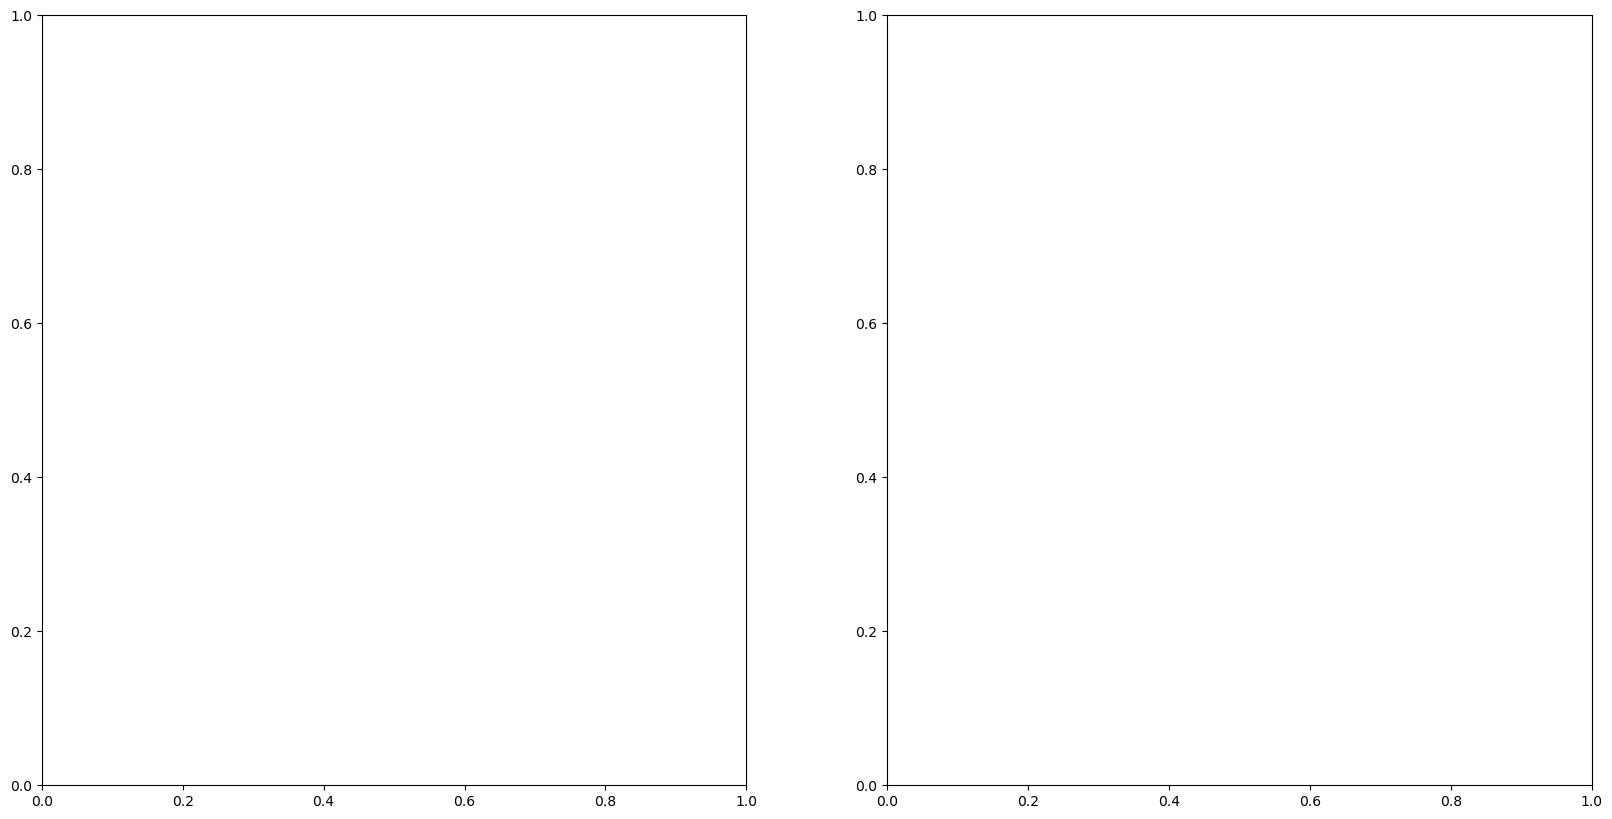

In [20]:
for epoch in range(epochs):
    print(f"\n>> Starting epoch {epoch}...")
    train()
    if epoch%50==0:
        test_network(img1, img2, net, detector)

print(f"\n>> Saving model to {save_path}")

torch.save({'net': net, 'state_dict': net.state_dict()}, save_path)

x = load_network_custom(save_path)

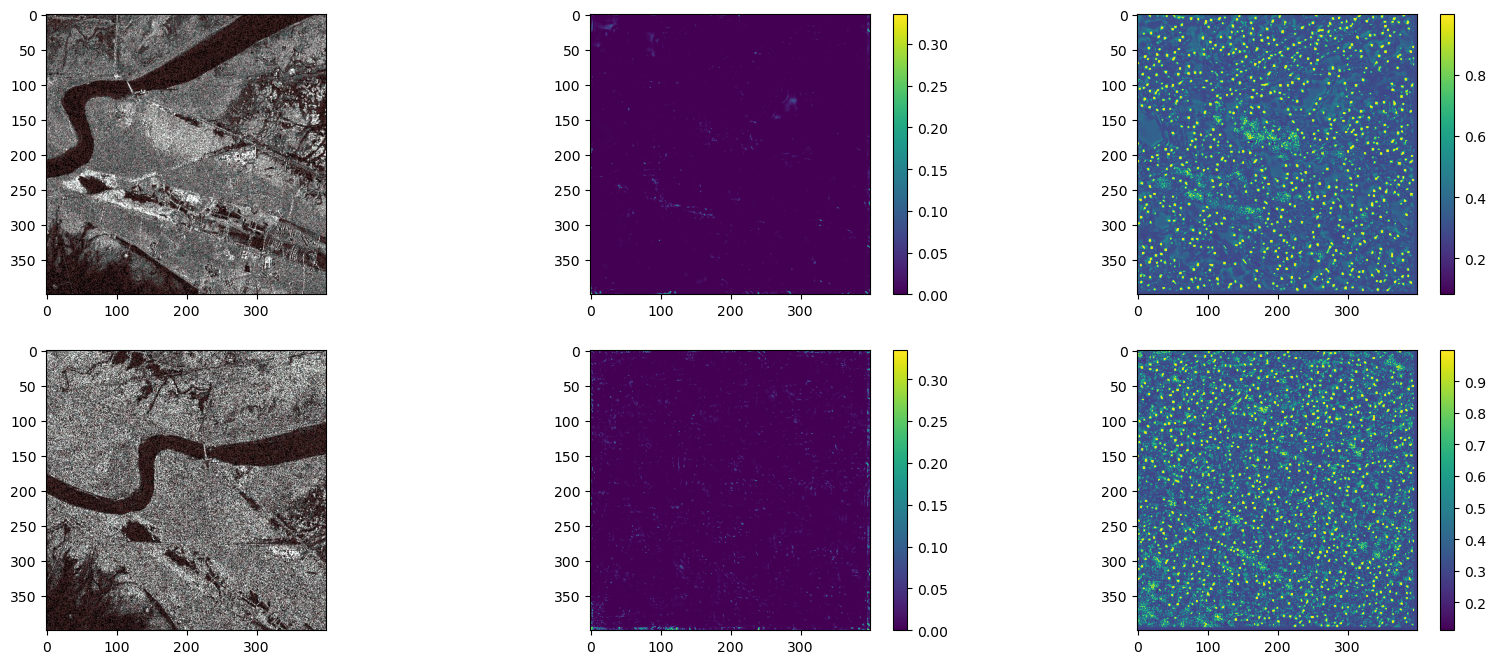

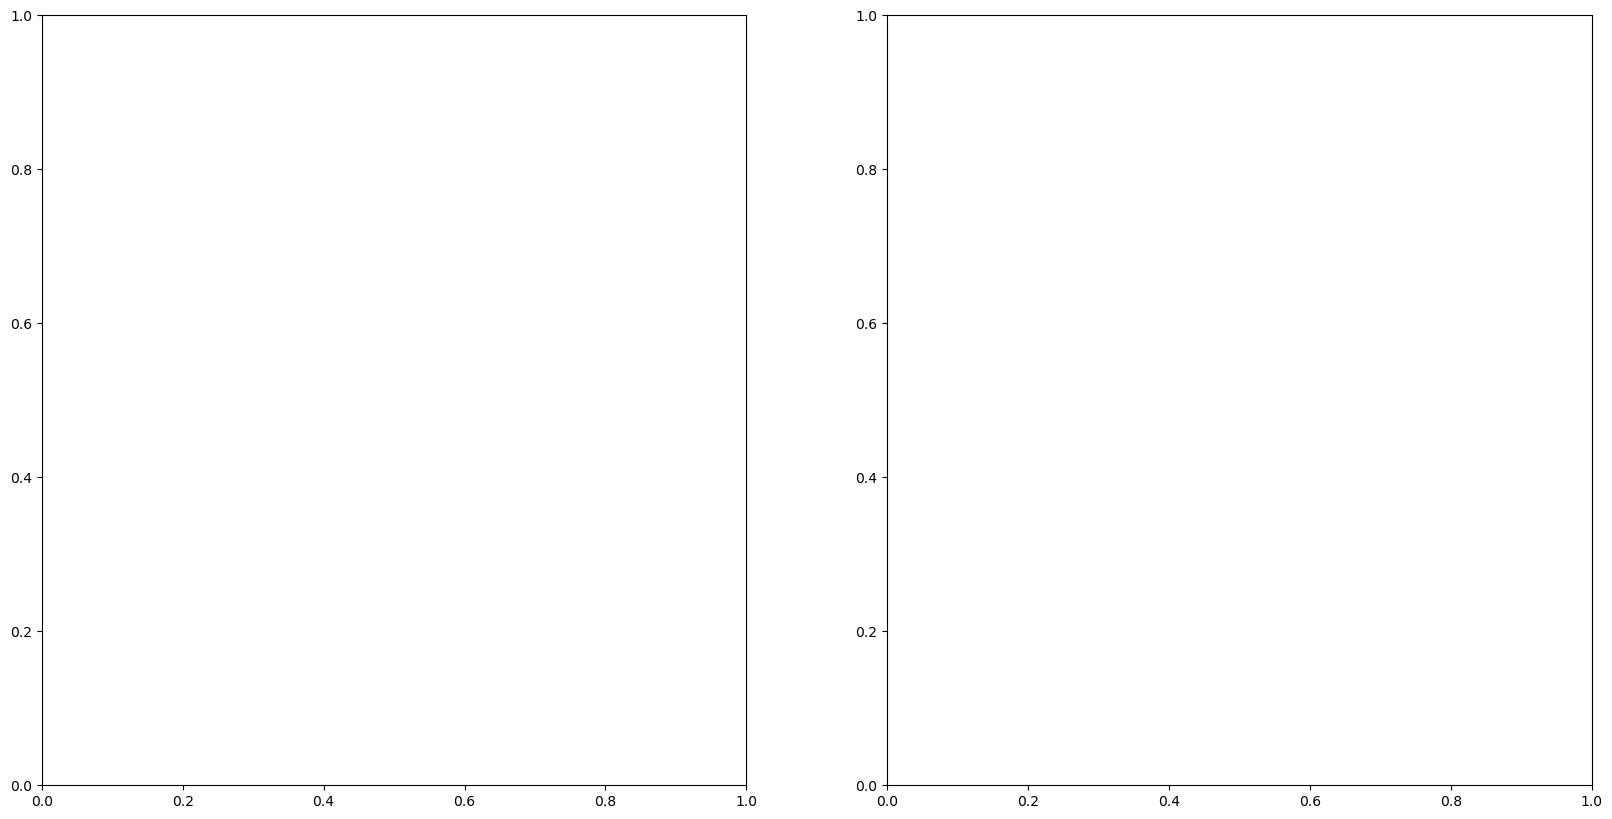

In [21]:
test_network(img1, img2, net, detector)

In [22]:
print(f"\n>> Saving model to {save_path}")

torch.save({'net': net, 'state_dict': net.state_dict()}, save_path)

x = load_network_custom(save_path)


>> Saving model to /kaggle/working//saved_model.pt

>> Creating net = Custom_Quad_L2Net_ConfCFS(
  (ops): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): GrowingCosineUnit()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): GrowingCosineUnit()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): GrowingCosineUnit()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): GrowingCosineUnit()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(